### Imports


In [1]:
import pandas as pd
import numpy as np
import os
import re
from dateutil.relativedelta import relativedelta
from statsmodels.tsa import seasonal
from matplotlib import pyplot as plt
from functools import reduce  # Operação de reduce para cálculo de média de uma lista
from datetime import datetime
import math
%matplotlib inline

#Configurações para exibição de tableas
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/Tiago/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


height has been deprecated.



### Infra code

In [2]:
# Nomes das colunas adicionadas ao dataframe
COLUNA_ANOMALIA_ACUMULADA = "anomalia_acumulada"
COLUNA_ANOMALIA_DO_MES = "anomalia_mensal"
COLUNA_MEDIA_MENSAL = "media_mensal"

# Todo mês possui 25 linhas por 38 colunas que dá 950
BLOCO_DE_DADOS_DE_UM_MES = 950
QUANTIDADE_DE_VALORES_DO_ARQUIVO = 573800  # (950 blocos x 604 meses,01/1964 até 04/2014)


class LatitudeColumns:

    def __init__(self):
        self.values = range(29, -21, -2)
        self.positive = 'N'
        self.negative = 'S'

    def get_all_columns(self):
        colum_names = []
        for value in self.values:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(value) + self.negative
            colum_names.append(colum_name)
        return colum_names

    def get_single_column(self, desired_value, human_readable=True):
        sub_values = []
        for value in self.values:
            if value != desired_value:
                continue
            sub_values.append(value)
        if human_readable:
            return self.parse_human_readable(sub_values)
        return sub_values

    def get_range(self, init, final, human_readable=True):
        final, init = self.switch(final, init)

        sub_values = []
        if init == final:
            return self.get_single_column(init, human_readable)

        for value in self.values:
            if (value > init) or (value < final):
                continue
            sub_values.append(value)

        if human_readable:
            return self.parse_human_readable(sub_values)

        return sub_values

    def switch(self, final, init):
        if final > init:
            aux = init
            init = final
            final = aux
        return final, init

    def parse_human_readable(self, list):
        colum_names = []
        for value in list:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(-value) + self.negative
            colum_names.append(colum_name)
        return colum_names

class LongitudeColumns:

    def __init__(self):
        #From map 60W to 15E(-17 because 'force' go to -15)
        self.values = range(59, -17, -2)
        self.positive = 'W'
        self.negative = 'E'

    def get_all_columns(self):
        colum_names = []
        for value in self.values:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(value) + self.negative
            colum_names.append(colum_name)
        return colum_names

    def get_single_column(self, desired_value, human_readable=True):
        sub_values = []
        for value in self.values:
            if value != desired_value:
                continue
            sub_values.append(value)
        if human_readable:
            return self.parse_human_readable(sub_values)
        return sub_values

    def get_range(self, init, final, human_readable=True):
        final, init = self.switch(final, init)

        sub_values = []
        if init == final:
            return self.get_single_column(init, human_readable)

        for value in self.values:
            if (value > init) or (value < final):
                continue
            sub_values.append(value)

        if human_readable:
            return self.parse_human_readable(sub_values)

        return sub_values

    def switch(self, final, init):
        if final > init:
            aux = init
            init = final
            final = aux
        return final, init

    def parse_human_readable(self, list):
        colum_names = []
        for value in list:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(-value) + self.negative
            colum_names.append(colum_name)
        return colum_names


def constroi_colunas_latitude_longitude(init_lat=29, end_lat=-21,
                                        init_long=59, end_long=-17):
    lat = LatitudeColumns().get_range(init_lat, end_lat)
    long = LongitudeColumns().get_range(init_long, end_long)
    colunas_do_data_frame = []
    for linha in lat:
        for coluna in long:
            lat_long = linha + "-" + coluna
            colunas_do_data_frame.append(lat_long)
    return colunas_do_data_frame


def carrega_array_com_valores_do_arquivo_geral(
        arquivo_com_decadas_de_anomalia="funceme_db/pseudo_tensao_x_anomalia/geral/_Dados_TSMvento_2014_04_anomx6414b04"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO

    conteudo_do_arquivo = open(arquivo_com_decadas_de_anomalia).read()
    conteudo_do_arquivo = conteudo_do_arquivo.replace("\n", "")

    # Carrega todos os dados de anomalia em um único array
    qtd_char_no_arquivo = 5
    # Todos os valores do arquivo em um único array. Não há separação de mês. Tudo está de forma sequencial
    valores_do_arquivo = []
    for rows_index in range(QUANTIDADE_DE_VALORES_DO_ARQUIVO):
        # slice data like (n:n+5)
        value = float(conteudo_do_arquivo[
                      rows_index * qtd_char_no_arquivo: rows_index * qtd_char_no_arquivo + qtd_char_no_arquivo])
        value = float("%.3f" % value)
        value /= 10
        valores_do_arquivo.append(value)
    return valores_do_arquivo


def carrega_array_com_valores_do_arquivo_mensal(file_name):
    file_content = open(file_name).read()

    # Remove header de um único arquivo
    file_content = file_content[25:]
    file_content = file_content.replace("\n", "")

    block_size = 5
    dados_do_arquivo = []
    for rows_index in range(BLOCO_DE_DADOS_DE_UM_MES):
        # slice data like (n:n+5)
        value = float(file_content[rows_index * block_size: rows_index * block_size + block_size])
        value = float("%.3f" % value)
        value /= 10
        dados_do_arquivo.append(value)

    return dados_do_arquivo


def merge_dados_do_diretorio(diretorio_arquivo_geral,diretorio_arquivo_individual):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO
    qtde = QUANTIDADE_DE_VALORES_DO_ARQUIVO
    lista_de_arquivos_individuais = []
    arquivos_do_diretorio = os.listdir(diretorio_arquivo_individual)

    quantidade_de_arquivos = 0
    # Adiciona apenas arquivos com extensão .22
    for arquivo in arquivos_do_diretorio:
        if arquivo.endswith(".22"):
            lista_de_arquivos_individuais.append(arquivo)
            quantidade_de_arquivos += 1

    valores_dos_arquivos = carrega_array_com_valores_do_arquivo_geral(diretorio_arquivo_geral)
    # Para cada arquivo na lista é feito append na lista full_data
    for arquivo in lista_de_arquivos_individuais:
        dados_mensais = carrega_array_com_valores_do_arquivo_mensal(diretorio_arquivo_individual + arquivo)
        for item in dados_mensais:
            valores_dos_arquivos.append(item)

    ##44 meses de 05/2014 até 12/2017
    qtde += quantidade_de_arquivos * BLOCO_DE_DADOS_DE_UM_MES  # Que dá 41800

    array_de_anomalias_por_mes = []
    for i in range(0, qtde, 950):
        anomalias_do_mes = valores_dos_arquivos[i:i + BLOCO_DE_DADOS_DE_UM_MES]
        array_de_anomalias_por_mes.append(anomalias_do_mes)
    return array_de_anomalias_por_mes


def inicia_funceme_data_frame(array_de_anomalias_por_mes):
    funceme_df = pd.DataFrame()
    for anomalias_do_mes in array_de_anomalias_por_mes:
        data = np.array(anomalias_do_mes)
        row_df = pd.DataFrame(data.reshape(-1, len(data)), columns=constroi_colunas_latitude_longitude())
        funceme_df = funceme_df.append(row_df)
    funceme_df.index = range(0, len(array_de_anomalias_por_mes), 1)
    # ### Setando indices baseados na data
    FORMAT = "%Y-%m"
    some_date_time1 = "1964-01"
    data_inicial = datetime.strptime(some_date_time1, FORMAT)
    indexes_data = []
    for i in range(len(array_de_anomalias_por_mes)):
        indexes_data.append(data_inicial + relativedelta(months=i))
    funceme_df = funceme_df.set_index(pd.DatetimeIndex(data=indexes_data))
    
    return funceme_df

def plota_coluna_do_dataframe(dataframe,titulo, nome_da_coluna, save_figure=False):
    fig, axarr = plt.subplots(1)
    fig.set_size_inches(8, 5)
    ax=dataframe[nome_da_coluna].plot( color='b', linestyle='-', grid=True)
    ax.set(xlabel="Year", ylabel="m2/s2")

    plt.title(titulo)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.axhline(0, color='black')
    if save_figure:
        plt.savefig("Imagens/"+titulo)
    else:        
        plt.show()
    
    plt.close()


In [3]:
array_dados_brutos_x = merge_dados_do_diretorio("funceme_db/pseudo_tensao_x_dados_brutos/geral/_Dados_TSMvento_2014_04_pwsx6414b04","funceme_db/pseudo_tensao_x_dados_brutos/individual/")
array_dados_brutos_y = merge_dados_do_diretorio("funceme_db/pseudo_tensao_y_dados_brutos/geral/_Dados_TSMvento_2014_04_pwsy6414b04","funceme_db/pseudo_tensao_y_dados_brutos/individual/")

In [4]:
pws = []
for month_index in range(len(array_dados_brutos_x)):
    scalar_product_list = []
    for value_index in range(len(array_dados_brutos_x[month_index])):
        scalar_product = math.sqrt(pow(array_dados_brutos_x[month_index][value_index],2) + pow(array_dados_brutos_y[month_index][value_index],2))
        if scalar_product == 14141.852781018475:
            scalar_product_list.append(np.nan)
        else:
            scalar_product_list.append(scalar_product)
    pws.append(scalar_product_list)


In [5]:
pws[0][0]

0.6324555320336759

In [6]:
pws[0][1]

10.855873986004076

In [7]:
dados_brutos_df = inicia_funceme_data_frame(pws)
dados_brutos_df.head()

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,29N-11W,29N-9W,29N-7W,29N-5W,29N-3W,29N-1W,29N-1E,29N-3E,29N-5E,29N-7E,29N-9E,29N-11E,29N-13E,29N-15E,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,27N-13W,27N-11W,27N-9W,27N-7W,27N-5W,27N-3W,27N-1W,27N-1E,27N-3E,27N-5E,27N-7E,27N-9E,27N-11E,27N-13E,27N-15E,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,25N-13W,25N-11W,25N-9W,25N-7W,25N-5W,25N-3W,25N-1W,25N-1E,25N-3E,25N-5E,25N-7E,25N-9E,25N-11E,25N-13E,25N-15E,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,23N-15W,23N-13W,23N-11W,23N-9W,23N-7W,23N-5W,23N-3W,23N-1W,23N-1E,23N-3E,23N-5E,23N-7E,23N-9E,23N-11E,23N-13E,23N-15E,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,21N-15W,21N-13W,21N-11W,21N-9W,21N-7W,21N-5W,21N-3W,21N-1W,21N-1E,21N-3E,21N-5E,21N-7E,21N-9E,21N-11E,21N-13E,21N-15E,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,19N-15W,19N-13W,19N-11W,19N-9W,19N-7W,19N-5W,19N-3W,19N-1W,19N-1E,19N-3E,19N-5E,19N-7E,19N-9E,19N-11E,19N-13E,19N-15E,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,...,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,7S-15E,9S-59W,9S-57W,9S-55W,9S-53W,9S-51W,9S-49W,9S-47W,9S-45W,9S-43W,9S-41W,9S-39W,9S-37W,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,9S-15E,11S-59W,11S-57W,11S-55W,11S-53W,11S-51W,11S-49W,11S-47W,11S-45W,11S-43W,11S-41W,11S-39W,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,11S-15E,13S-59W,13S-57W,13S-55W,13S-53W,13S-51W,13S-49W,13S-47W,13S-45W,13S-43W,13S-41W,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,13S-15E,15S-59W,15S-57W,15S-55W,15S-53W,15S-51W,15S-49W,15S-47W,15S-45W,15S-43W,15S-41W,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,15S-15E,17S-59W,17S-57W,17S-55W,17S-53W,17S-51W,17S-49W,17S-47W,17S-45W,17S-43W,17S-41W,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,17S-13E,17S-15E,19S-59W,19S-57W,19S-55W,19S-53W,19S-51W,19S-49W,19S-47W,19S-45W,19S-43W,19S-41W,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,19S-15E
1964-01-01,0.632456,10.855874,16.995588,20.727035,22.036787,20.506097,15.060212,11.806778,13.165485,15.928905,18.720043,19.382982,19.275373,19.183847,18.293715,17.761194,18.120155,17.60

### Treating missing data

In [8]:
dados_brutos_df = dados_brutos_df.replace(14141.852781018475, np.nan)
dados_brutos_df.head(5)

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,29N-11W,29N-9W,29N-7W,29N-5W,29N-3W,29N-1W,29N-1E,29N-3E,29N-5E,29N-7E,29N-9E,29N-11E,29N-13E,29N-15E,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,27N-13W,27N-11W,27N-9W,27N-7W,27N-5W,27N-3W,27N-1W,27N-1E,27N-3E,27N-5E,27N-7E,27N-9E,27N-11E,27N-13E,27N-15E,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,25N-13W,25N-11W,25N-9W,25N-7W,25N-5W,25N-3W,25N-1W,25N-1E,25N-3E,25N-5E,25N-7E,25N-9E,25N-11E,25N-13E,25N-15E,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,23N-15W,23N-13W,23N-11W,23N-9W,23N-7W,23N-5W,23N-3W,23N-1W,23N-1E,23N-3E,23N-5E,23N-7E,23N-9E,23N-11E,23N-13E,23N-15E,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,21N-15W,21N-13W,21N-11W,21N-9W,21N-7W,21N-5W,21N-3W,21N-1W,21N-1E,21N-3E,21N-5E,21N-7E,21N-9E,21N-11E,21N-13E,21N-15E,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,19N-15W,19N-13W,19N-11W,19N-9W,19N-7W,19N-5W,19N-3W,19N-1W,19N-1E,19N-3E,19N-5E,19N-7E,19N-9E,19N-11E,19N-13E,19N-15E,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,...,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,7S-15E,9S-59W,9S-57W,9S-55W,9S-53W,9S-51W,9S-49W,9S-47W,9S-45W,9S-43W,9S-41W,9S-39W,9S-37W,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,9S-15E,11S-59W,11S-57W,11S-55W,11S-53W,11S-51W,11S-49W,11S-47W,11S-45W,11S-43W,11S-41W,11S-39W,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,11S-15E,13S-59W,13S-57W,13S-55W,13S-53W,13S-51W,13S-49W,13S-47W,13S-45W,13S-43W,13S-41W,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,13S-15E,15S-59W,15S-57W,15S-55W,15S-53W,15S-51W,15S-49W,15S-47W,15S-45W,15S-43W,15S-41W,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,15S-15E,17S-59W,17S-57W,17S-55W,17S-53W,17S-51W,17S-49W,17S-47W,17S-45W,17S-43W,17S-41W,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,17S-13E,17S-15E,19S-59W,19S-57W,19S-55W,19S-53W,19S-51W,19S-49W,19S-47W,19S-45W,19S-43W,19S-41W,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,19S-15E
1964-01-01,0.632456,10.855874,16.995588,20.727035,22.036787,20.506097,15.060212,11.806778,13.165485,15.928905,18.720043,19.382982,19.275373,19.183847,18.293715,17.761194,18.120155,17.60

In [9]:
## Removing not ocean area(99998)

In [10]:
dados_brutos_df = dados_brutos_df.dropna(axis=1, how='any')
dados_brutos_df.head(2)

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-19W,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E
1964-01-01,0.632456,10.855874,16.995588,20.727035,22.036787,20.506097,15.060212,11.806778,13.165485,15.928905,18.720043,19.382982,19.275373,19.183847,18.293715,17.761194,18.120155,17.602557,13.476646,7.528612,4.560702,8.732125,11.524756,

## Add column monthly mean

In [11]:
def adiciona_media_mensal(dataframe):
    # Cria média para cada mês adicionando a coluna "media_mensal"
    media_da_figura_no_mes = []

    for date, row in dataframe.iterrows():
        media = (reduce(lambda x, y: x + y, row) / len(row))
        media_da_figura_no_mes.append(media)

    # Cria nova coluna chamada media_mensal e adiciona ao dataframe da funceme(funceme_df)
    dataframe.loc[:, "%s" % COLUNA_MEDIA_MENSAL] = pd.Series(media_da_figura_no_mes, index=dataframe.index)
    return dataframe

### Climatology

In [12]:
def calcula_climatologia_para_dataframe(dataframe):
    # Cria dicionário de médias anuais
    medias_anuais = {}
    for mes in range(1, 13, 1):
        medias_anuais[mes] = []

    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        medias_anuais[data.month].append(row[('%s' % COLUNA_MEDIA_MENSAL)])

    # Calcula climatologia para cada mês
    climatologias_mensais = {}
    for mes in range(1, 13, 1):
        climatologias_mensais[mes] = reduce(lambda x, y: x + y, medias_anuais[mes]) / len(medias_anuais[mes])
    return climatologias_mensais

## Anomaly

In [13]:
def adiciona_anomalia(dataframe):
    climatologias_mensais = calcula_climatologia_para_dataframe(dataframe)

    ### Calculando anomalias
    anomalia = []
    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        anomalia_do_mes = row[COLUNA_MEDIA_MENSAL] - climatologias_mensais[data.month]
        anomalia.append(anomalia_do_mes)
    dataframe.loc[:, COLUNA_ANOMALIA_DO_MES] = pd.Series(anomalia, index=dataframe.index)
    dataframe.head(2)
    return dataframe

### Cumulative Anomaly

In [14]:
def adiciona_anomalia_acumulada(dataframe):
    anomalia_acumulada = []
    # Calcula anomalia acumulada
    for index in range(len(dataframe.index)):
        if index == 0:
            anomalia_acumulada.append(dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES])
            continue
        anterior = anomalia_acumulada[index-1]
        atual = dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES]
        anomalia_acumulada.append(float("%.3f" % (atual+anterior)))

    dataframe.loc[:, COLUNA_ANOMALIA_ACUMULADA] = pd.Series(anomalia_acumulada, index=dataframe.index)
    return dataframe

In [15]:
dados_brutos_df = adiciona_media_mensal(dados_brutos_df)
dados_brutos_df.head()

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,media_mensal
1964-01-01,0.632456,10.855874,16.995588,20.727035,22.036787,20.506097,15.060212,11.806778,13.165485,15.928905,18.720043,19.382982,19.275373,19.183847,18.293715,17.761194,18.120155,17.602557,13.476646,7.528612,4.560702,8.732125,11.5

In [16]:
dados_brutos_df = adiciona_anomalia(dados_brutos_df)
dados_brutos_df.head()

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,media_mensal,anomalia_mensal
1964-01-01,0.632456,10.855874,16.995588,20.727035,22.036787,20.506097,15.060212,11.806778,13.165485,15.928905,18.720043,19.382982,19.275373,19.183847,18.293715,17.761194,18.120155,17.602557,13.476646,7.528612,4.560702,8.73

In [17]:
dados_brutos_df = adiciona_anomalia_acumulada(dados_brutos_df)
dados_brutos_df.head()

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,media_mensal,anomalia_mensal,anomalia_acumulada
1964-01-01,0.632456,10.855874,16.995588,20.727035,22.036787,20.506097,15.060212,11.806778,13.165485,15.928905,18.720043,19.382982,19.275373,19.183847,18.293715,17.761194,18.120155,17.602557,13.476646,7.528612,4

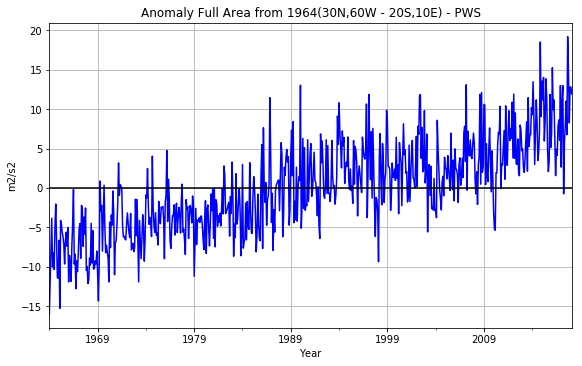

In [18]:
plota_coluna_do_dataframe(dados_brutos_df, 'Anomaly Full Area from 1964(30N,60W - 20S,10E) - PWS',COLUNA_ANOMALIA_DO_MES)

### Filtering area

In [19]:
dados_brutos_df = dados_brutos_df.loc['2003-01-01':'2017-12-01']
dados_brutos_df.head()

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,media_mensal,anomalia_mensal,anomalia_acumulada
2003-01-01,26.639069,22.238030,20.360010,23.338380,26.541477,28.876461,28.115654,25.044960,24.030814,30.218537,38.281719,33.903392,29.805536,25.994230,26.073166,29.468797,34.363935,39.731600,42.691920,43.490919

### ATN 20N-0N / 50W-20W

In [20]:
colunas_atn_n = constroi_colunas_latitude_longitude(init_lat=19, end_lat=0,
                                                    init_long=49, end_long=20)

ATN_df = pd.DataFrame(dados_brutos_df, index=dados_brutos_df.index, columns=colunas_atn_n)
ATN_df = ATN_df.dropna(axis=1, how='any')

#Média mensal
adiciona_media_mensal(ATN_df)

#Climatologia
calcula_climatologia_para_dataframe(ATN_df)

#Anomalia
ATN_df = adiciona_anomalia(ATN_df)

#AnomaliaCumulativa
ATN_df = adiciona_anomalia_acumulada(ATN_df)
ATN_df.head()

,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,7N-49W,7N-47W,7N-45W,7N-43W,7N-41W,7N-39W,7N-37W,7N-35W,7N-33W,7N-31W,7N-29W,7N-27W,7N-25W,7N-23W,7N-21W,5N-49W,5N-47W,5N-45W,5N-43W,5N-41W,5N-39W,5N-37W,5N-35W,5N-33W,5N-31W,5N-29W,5N-27W,5N-25W,5N-23W,5N-21W,3N-49W,3N-47W,3N-45W,3N-43W,3N-41W,3N-39W,3N-37W,3N-35W,3N-33W,3N-31W,3N-29W,3N-27W,3N-25W,3N-23W,3N-21W,1N-49W,1N-47W,1N-45W,1N-43W,1N-41W,1N-39W,1N-37W,1N-35W,1N-33W,1N-31W,1N-29W,1N-27W,1N-25W,1N-23W,1N-21W,media_mensal,anomalia_mensal,anomalia_acumulada
2003-01-01,63.325587,61.768115,60.869122,61.850546,64.165100,67.995441,73.227932,79.389231,87.297480,96.290602,105.081492,115.084751,118.683487,108.123725,90.222669,68.628420,67.783258,67.882251,70.007142,72.296196,75.361794,79.404030,85.682437,96.235129,106.740152,117.184299,125.310814,127.890148,113.857191,89.262590,72.917762,74.083736,75.470855,77.162944,77.709781,79.514150,82.489878,86.300058,94.615062,104.817222,115.414470,122.787662,124.009072,110.091053,86.040107,78.266340,81.676006,83.696834,83.207752,82.384768,82.096589,83.209435,84.225471,86.969075,93.963237,102.565686,109.737505,110.276833,98.714234,78.132708,84.853815,90.111320,92.589848,90.524030,87.444840,84.926439,83.763536,83.586243,81.948093,82.851494,88.325817,95.511779,94.400530,83.523051,67.277113,87.447413,94.794304,98.567337,97.112821,92.332659,87.995966,85.234969,83.413728,81.072868,78.565387,79.630396,81.934852,79.304224,68.921550,53.139157,84.630786,93.051814,98.011479,98.517257,94.356134,88.665495,83.712365,78.855628,76.189894,73.392438,71.081503,69.410374,64.413120,53.651561,37.232378,77.909242,85.147636,89.600056,90.505525,88.622458,83.164656,75.484899,67.169189,61.483331,57.783129,57.283942,54.481189,47.908767,36.861091,23.323808,66.795584,71.665403,74.861539,75.010533,73.151897,69.068444,59.862259,49.825495,41.740149,38.468949,38.873770,35.981801,30.004166,20.800240,12.137957,53.562020,56.583567,57.264038,57.020172,55.625983,51.648427,43.200579,34.079466,26.306843,22.919206,22.203603,19.233824,14.417004,8.988882,7.308215,75.540428,9.271685,9.271685
2003-02-01,79.891051,78.532350,76.135931,72.692022,71.582400,73.124893,73.467884,74.255033,74.890120,76.362294,78.559595,81.492331,84.136199,82.722488,80.543777,83.080022,78.888529,73.720079,69.193425,68.938596,71.957348,74.232136,76.249328,76.852651,77.772103,79.348661,82.720010,86.195360,86.439863,84.090249,88.433591,82.113336,75.112982,70.852029,70.808545,73.127355,77.095331,79.956488,80.920022,81.116275,81.112823,83.547412,86.493063,87.634012,84.838965,92.059383,85.722576,78.730426,75.262873,74.043028,75.078692,79.425940,83.390767,85.304631,84.168997,81.024688,81.849191,82.620881,82.552589,77.563200,91.720281,88.309116,84.482247,81.668231,78.128676,76.837035,80.365291,84.740191,87.307503,85.719776,79.781828,76.862540,74.946648,71.721824,64.128075,90.000222,91.349494,91.748569,88.665890,83.270703,78.810469,79.697240,84.016189,86.923932,84.680872,77.771203,71.494475,66.703673,58.959054,48.325976,88.393778,92.468589,94.615538,91.382383,85.302110,79.852990,79.483646,81.646372,83.604366,82.570273,76.505229,67.978600,59.944141,48.485565,34.259743,84.778299,87.162492,88.902756,87.785306,83.122680,77.075612,76.118986,77.128270,79.154596,78.070801,73.201093,64.672173,53.565101,40.174121,24.593495,74.828070,74.949650,76.840094,77.781874,74.044379,68.323715,6

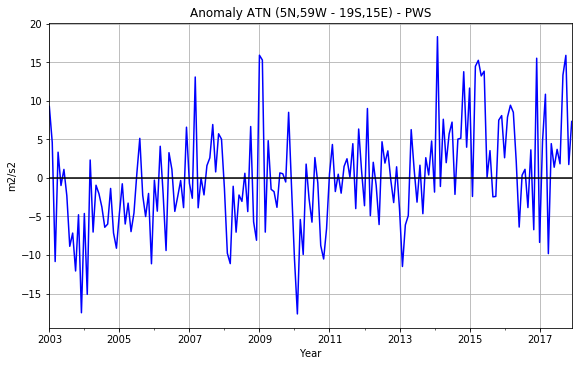

In [21]:
plota_coluna_do_dataframe(ATN_df, 'Anomaly ATN (5N,59W - 19S,15E) - PWS',COLUNA_ANOMALIA_DO_MES)

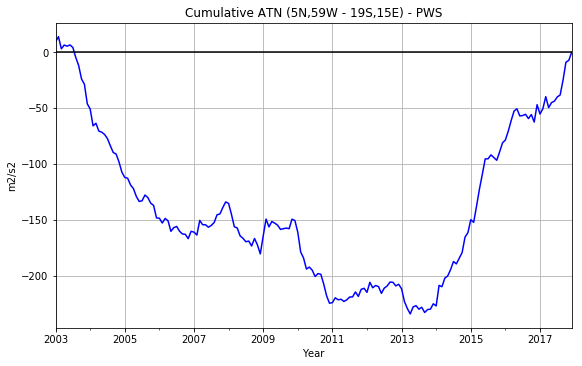

In [22]:
plota_coluna_do_dataframe(ATN_df, 'Cumulative ATN (5N,59W - 19S,15E) - PWS',COLUNA_ANOMALIA_ACUMULADA)

### ATS 0N-18W / 30W-0W

In [23]:
colunas_ats_s = constroi_colunas_latitude_longitude(init_lat=-1, end_lat=-17,
                                                    init_long=29, end_long=0)

ATS_df = pd.DataFrame(dados_brutos_df, index=dados_brutos_df.index, columns=colunas_ats_s)
ATS_df = ATS_df.dropna(axis=1, how='any')

#Média mensal
adiciona_media_mensal(ATS_df)

#Climatologia
calcula_climatologia_para_dataframe(ATS_df)

#Anomalia
ATS_df = adiciona_anomalia(ATS_df)

#AnomaliaCumulativa
ATS_df = adiciona_anomalia_acumulada(ATS_df)
ATS_df.head()

,1S-29W,1S-27W,1S-25W,1S-23W,1S-21W,1S-19W,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,media_mensal,anomalia_mensal,anomalia_acumulada
2003-01-01,12.965338,11.485643,10.057833,11.900420,15.415901,18.804255,22.271282,24.335365,26.201718,28.081667,28.688151,27.091327,25.056935,24.213220,22.959312,14.439183,14.223924,16.058954,20.100995,23.424133,26.365128,30.085212,32.091432,32.690671,32.442256,31.886361,31.107716,28.860007,27.849776,27.366037,18.533483,19.581624,22.507776,25.583784,28.445914,30.649307,32.901368,34.266748,33.936558,32.485227,31.461246,30.066593,28.577264,27.587316,28.134143,24.385241,25.715754,28.461377,29.646754,30.527529,31.620405,32.172038,32.662057,32.598313,31.839912,30.341556,28.663042,27.620463,26.637755,26.209159,34.349381,35.085182,35.852197,34.084747,32.780024,32.102959,31.334486,30.830180,30.668714,30.613886,30.255247,29.443166,28.146048,26.641321,25.005999,43.233899,44.107256,43.316971,40.478389,36.597814,34.030868,31.894357,30.461123,29.948289,30.048627,30.613886,30.902751,30.353418,29.000000,27.089666,43.700458,46.481179,46.550295,44.964208,40.408539,36.563643,33.205120,31.607752,31.140006,30.720026,30.101495,30.972569,33.069170,33.823660,32.756221,38.455299,41.734638,43.919244,43.809816,41.986903,38.212302,35.282290,33.735590,31.952621,29.210443,28.081489,30.121255,34.030868,38.026964,41.020970,32.125379,35.249539,38.851512,40.204477,40.010124,38.021704,36.758264,35.431624,31.662280,28.049421,26.600188,29.363923,34.206724,41.663533,48.085133,30.915108,-11.726068,-11.726068
2003-02-01,32.890728,28.992758,23.038446,19.102356,24.196074,32.037010,37.865288,37.797619,32.241898,27.513633,25.976335,22.225211,18.829764,16.949926,16.923948,31.798428,28.257388,25.601758,27.406569,33.964982,39.994000,42.723413,40.317242,34.281190,30.661539,29.716830,27.719488,24.646501,22.073514,22.246123,44.451884,41.746856,39.503544,40.055586,42.472815,45.438310,42.990697,37.320906,32.097508,29.343653,28.935273,28.714108,27.423530,26.117427,26.416851,53.904824,53.243685,51.276700,49.502525,48.544928,47.808890,42.464691,36.726693,32.424836,30.066094,28.987066,28.285155,27.503636,26.599624,26.523951,58.219241,57.609027,55.181972,51.679977,48.386465,45.723080,42.293853,38.434620,35.077201,33.320864,31.780497,29.464555,26.605639,24.299177,23.883467,60.997787,58.907470,54.149792,48.193776,44.292324,42.269256,42.727509,41.690886,39.846957,38.463749,36.877364,33.199096,28.469106,24.640008,21.654099,61.683466,58.096213,51.237877,43.476200,38.454129,39.155587,42.333202,43.620637,42.878549,41.703357,40.251708,36.547230,32.596932,28.683270,23.840302,58.212799,53.572101,45.316002,37.181850,32.742633,33.651449,38.569677,41.611176,41.094647,39.330904,37.808597,36.583330,35.564730,33.050567,29.800671,54.374351,48.269452,38.835293,30.536044,26.637192,28.397535,32.763394,36.884821,35.456593,33.400898,32.477839,34.630189,36.472455,35.927288,34.717431,36.678901,-4.391429,-16.117000
2003-03-01,17.695480,14.410066,10.493808,5.215362,2.385372,1.860108,3.584690,6.753518,12.034118,17.535393,20.727277,18.891532,16.726327,15.695222,16.868906,21.520455,20.192078,18.023596,15.893709,14.167569,

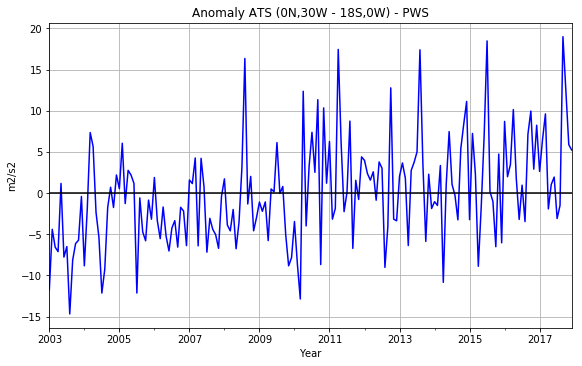

In [24]:
plota_coluna_do_dataframe(ATS_df, 'Anomaly ATS (0N,30W - 18S,0W) - PWS',COLUNA_ANOMALIA_DO_MES)

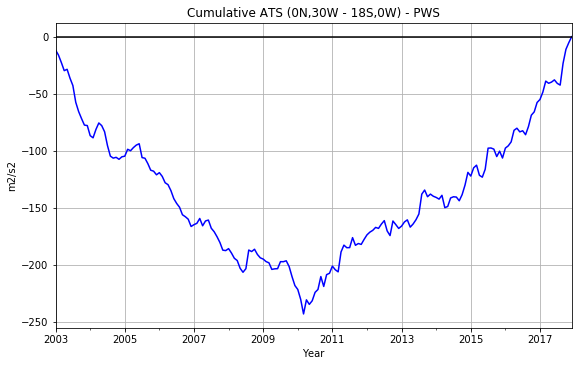

In [25]:
plota_coluna_do_dataframe(ATS_df, 'Cumulative ATS (0N,30W - 18S,0W) - PWS',COLUNA_ANOMALIA_ACUMULADA)

### TN (27N,59W - 5N,15E)

In [26]:
# Construir colunas
colunas_tn = constroi_colunas_latitude_longitude(init_lat=27, end_lat=3,
                                                    init_long=59, end_long=17)

#Montar dataframe
tn_df=pd.DataFrame(dados_brutos_df, index=dados_brutos_df.index, columns=colunas_tn)

#Remover NAN
tn_df = tn_df.replace(9999.8, np.nan)
tn_df = tn_df.dropna(axis=1, how='any')

#Calcula media mensal
adiciona_media_mensal(tn_df)

#Calcular climatologia
# calcula_climatologia_para_dataframe(tn_df)

#Calcular anomalia mensal
tn_df = adiciona_anomalia(tn_df)

#Montar anomalia acumulada
tn_df = adiciona_anomalia_acumulada(tn_df)
tn_df.head()

,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,7N-57W,7N-55W,7N-53W,7N-51W,7N-49W,7N-47W,7N-45W,7N-43W,7N-41W,7N-39W,7N-37W,7N-35W,7N-33W,7N-31W,7N-29W,7N-27W,7N-25W,7N-23W,7N-21W,7N-19W,7N-17W,5N-51W,5N-49W,5N-47W,5N-45W,5N-43W,5N-41W,5N-39W,5N-37W,5N-35W,5N-33W,5N-31W,5N-29W,5N-27W,5N-25W,5N-23W,5N-21W,5N-19W,5N-17W,3N-49W,3N-47W,3N-45W,3N-43W,3N-41W,3N-39W,3N-37W,3N-35W,3N-33W,3N-31W,3N-29W,3N-27W,3N-25W,3N-23W,3N-21W,3N-19W,3N-17W,media_mensal,anomalia_mensal,anomalia_acumulada
2003-01-01,13.020753,12.355566,12.712199,16.005624,19.160637,21.683404,21.148286,21.079137,26.427259,34.625569,42.205213,40.534923,38.533232,36.307713,36.100554,37.655411,43.164800,49.645946,54.465585,57.924951,57.346752,59.789046,12.756175,13.514807,16.124515,19.021304,21.566873,23.341380,25.793798,29.696633,36.378565,43.880861,50.052173,50.771843,50.581123,49.684001,49.274131,50.680568,57.733872,64.785338,71.294951,73.912448,70.358013,66.617865,27.609056,28.915394,31.755472,35.295609,37.285520,38.958953,41.619467,44.420716,48.302795,52.474756,57.012630,60.617654,62.568123,62.771411,64.153722,67.580471,77.086056,83.513472,87.185779,85.314125,78.368999,68.986955,37.064538,41.552016,45.112415,49.166350,51.946992,54.187176,53.934034,54.457415,55.825890,57.701386,61.188561,66.191314,71.440955,74.557428,80.034118,86.053007,97.137017,102.370015,98.432363,88.882957,76.029271,62.760258,41.658733,48.530918,53.528030,57.924951,61.732406,63.325587,61.768115,60.869122,61.850546,64.165100,67.995441,73.227932,79.389231,87.297480,96.290602,105.081492,115.084751,118.683487,108.123725,90.222669,68.781538,52.275042,48.500928,54.529717,59.940387,64.100078,67.407195,68.628420,67.783258,67.882251,70.007142,72.296196,75.361794,79.404030,85.682437,96.235129,106.740152,117.184299,125.310814,127.890148,113.857191,89.262590,64.095320,47.201695,56.667539,60.607013,65.659729,69.751846,72.015346,72.917762,74.083736,75.470855,77.162944,77.709781,79.514150,82.489878,86.300058,94.615062,104.817222,115.414470,122.787662,124.009072,110.091053,86.040107,61.725845,47.461142,61.815856,64.548277,69.236190,73.794444,76.339374,78.266340,81.676006,83.696834,83.207752,82.384768,82.096589,83.209435,84.225471,86.969075,93.963237,102.565686,109.737505,110.276833,98.714234,78.132708,57.050329,42.462336,62.233753,65.008307,68.860802,74

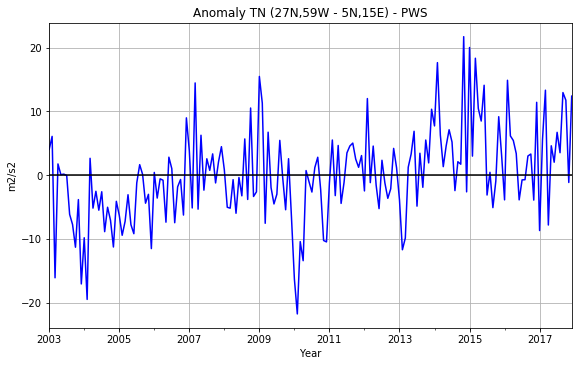

In [27]:
plota_coluna_do_dataframe(tn_df, 'Anomaly TN (27N,59W - 5N,15E) - PWS',COLUNA_ANOMALIA_DO_MES)

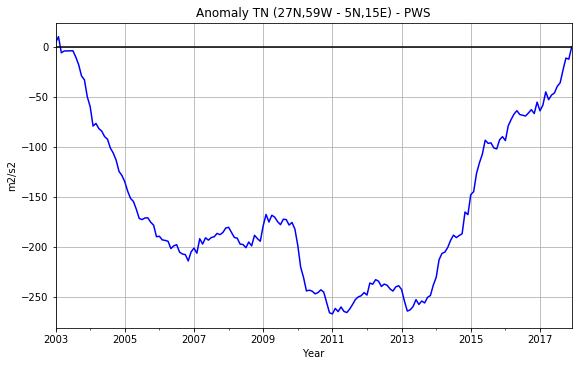

In [28]:
plota_coluna_do_dataframe(tn_df, 'Anomaly TN (27N,59W - 5N,15E) - PWS',COLUNA_ANOMALIA_ACUMULADA)

### TS (5N,59W - 20S,15E)

In [29]:
# Construir colunas
colunas_ts = constroi_colunas_latitude_longitude(init_lat=5, end_lat=-20,
                                                    init_long=59, end_long=-17)

#Montar dataframe
ts_df=pd.DataFrame(dados_brutos_df, index=dados_brutos_df.index, columns=colunas_ts)

#Filtrar por data
ts_df = ts_df.loc['2003-01-01':'2017-12-01']

#Remover NAN
ts_df = ts_df.replace(9999.8, np.nan)
ts_df = ts_df.dropna(axis=1, how='any')

#Calcula media mensal
adiciona_media_mensal(ts_df)

#Calcular climatologia
# calcula_climatologia_para_dataframe(ts_df)

#Calcular anomalia mensal
ts_df = adiciona_anomalia(ts_df)

#Montar anomalia acumulada
ts_df = adiciona_anomalia_acumulada(ts_df)
ts_df.head()

,5N-51W,5N-49W,5N-47W,5N-45W,5N-43W,5N-41W,5N-39W,5N-37W,5N-35W,5N-33W,5N-31W,5N-29W,5N-27W,5N-25W,5N-23W,5N-21W,5N-19W,5N-17W,5N-15W,5N-13W,5N-11W,5N-9W,5N-7W,5N-5W,5N-3W,5N-1W,5N-1E,5N-3E,5N-5E,5N-7E,5N-9E,3N-49W,3N-47W,3N-45W,3N-43W,3N-41W,3N-39W,3N-37W,3N-35W,3N-33W,3N-31W,3N-29W,3N-27W,3N-25W,3N-23W,3N-21W,3N-19W,3N-17W,3N-15W,3N-13W,3N-11W,3N-9W,3N-7W,3N-5W,3N-3W,3N-1W,3N-1E,3N-3E,3N-5E,3N-7E,3N-9E,1N-49W,1N-47W,1N-45W,1N-43W,1N-41W,1N-39W,1N-37W,1N-35W,1N-33W,1N-31W,1N-29W,1N-27W,1N-25W,1N-23W,1N-21W,1N-19W,1N-17W,1N-15W,1N-13W,1N-11W,1N-9W,1N-7W,1N-5W,1N-3W,1N-1W,1N-1E,1N-3E,1N-5E,1N-7E,1N-9E,1S-47W,1S-45W,1S-43W,1S-41W,1S-39W,1S-37W,1S-35W,1S-33W,1S-31W,1S-29W,1S-27W,1S-25W,1S-23W,1S-21W,1S-19W,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,media_mensal,anomalia_mensal,anomalia_acumulada
2003-01-01,72.340583,77.909242,85.147636,89.600056,90.505525,88.622458,83.164656,75.484899,67.169189,61.483331,57.783129,57.283942,54.481189,47.908767,36.861091,23.323808,12.397580,7.518643,6.438167,5.661272,3.140064,0.905539,3.590265,8.075271,10.877959,10.868303,8.906739,10.264989,13.312400,18.610212,24.583938,66.795584,71.665403,74.861539,75.010533,73.151897,69.068444,59.862259,49.825495,41.740149,38.468949,38.873770,35.981801,30.004166,20.800240,12.137957,5.731492,0.905539,2.692582,4.854894,6.670832,7.702597,8.464632,9.818350,11.335784,11.933147,11.321661,12.496399,15.001333,19.365949,24.574784,53.562020,56.583567,57.264038,57.020172,55.625983,51.648427,43.200579,34.079466,26.306843,22.919206,22.203603,19.233824,14.417004,8.988882,7.308215,8.655634,10.135581,11.992081,15.245327,17.663805,19.087430,18.054362,17.283807,17.049633,16.807736,16.062690,16.469366,17.364331,20.083824,23.943475,43.807077,44.099093,44.230872,43.509194,40.445643,34.012498,26.512638,19.985995,15.566631,12.965338,11.485643,10.057833,11.900420,15.415901,18.804255,22.271282,24.335365,26.201718,28.081667,28.688151,27.091327,25.056935,24.213220,22.959312,22.231509,20.792787,19.709135,20.194306,21.073680,39.559196,40.376354,38.651779,33.947754,27.414230,20.949702,16.252077,14.439183,14.223924,16.058954,20.100995,23.424133,26.365128,30.085212,32.091432,32.690671,32.442256,31.886361,31.107716,28.860007,27.849776,27.366037,26.906691,24.083189,21.149232,18.921416,16.995588,3

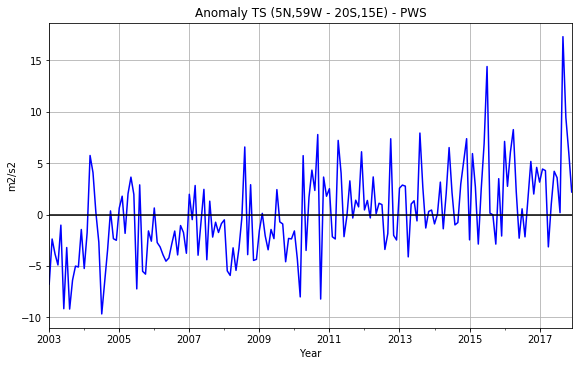

In [30]:
plota_coluna_do_dataframe(ts_df, 'Anomaly TS (5N,59W - 20S,15E) - PWS',COLUNA_ANOMALIA_DO_MES)

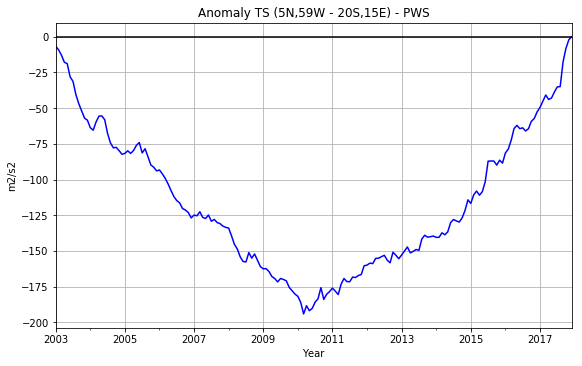

In [31]:
plota_coluna_do_dataframe(ts_df, 'Anomaly TS (5N,59W - 20S,15E) - PWS',COLUNA_ANOMALIA_ACUMULADA)

### EQW (3N,40W - 3S,20W)

In [32]:
# Construir colunas
colunas_eqw = constroi_colunas_latitude_longitude(init_lat=3, end_lat=-3,
                                                    init_long=39, end_long=-21)

#Montar dataframe
eqw_df=pd.DataFrame(dados_brutos_df, index=dados_brutos_df.index, columns=colunas_eqw)

#Filtrar por data
eqw_df = eqw_df.loc['2003-01-01':'2017-12-01']

#Remover NAN
eqw_df = eqw_df.replace(9999.8, np.nan)
eqw_df = eqw_df.dropna(axis=1, how='any')

#Calcula media mensal
adiciona_media_mensal(eqw_df)

#Calcular climatologia
# calcula_climatologia_para_dataframe(eqw_df)

#Calcular anomalia mensal
eqw_df = adiciona_anomalia(eqw_df)

#Montar anomalia acumulada
eqw_df = adiciona_anomalia_acumulada(eqw_df)
eqw_df.head()

,3N-39W,3N-37W,3N-35W,3N-33W,3N-31W,3N-29W,3N-27W,3N-25W,3N-23W,3N-21W,3N-19W,3N-17W,3N-15W,3N-13W,3N-11W,3N-9W,3N-7W,3N-5W,3N-3W,3N-1W,3N-1E,3N-3E,3N-5E,3N-7E,3N-9E,1N-39W,1N-37W,1N-35W,1N-33W,1N-31W,1N-29W,1N-27W,1N-25W,1N-23W,1N-21W,1N-19W,1N-17W,1N-15W,1N-13W,1N-11W,1N-9W,1N-7W,1N-5W,1N-3W,1N-1W,1N-1E,1N-3E,1N-5E,1N-7E,1N-9E,1S-39W,1S-37W,1S-35W,1S-33W,1S-31W,1S-29W,1S-27W,1S-25W,1S-23W,1S-21W,1S-19W,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,media_mensal,anomalia_mensal,anomalia_acumulada
2003-01-01,69.068444,59.862259,49.825495,41.740149,38.468949,38.873770,35.981801,30.004166,20.800240,12.137957,5.731492,0.905539,2.692582,4.854894,6.670832,7.702597,8.464632,9.818350,11.335784,11.933147,11.321661,12.496399,15.001333,19.365949,24.574784,51.648427,43.200579,34.079466,26.306843,22.919206,22.203603,19.233824,14.417004,8.988882,7.308215,8.655634,10.135581,11.992081,15.245327,17.663805,19.087430,18.054362,17.283807,17.049633,16.807736,16.062690,16.469366,17.364331,20.083824,23.943475,40.445643,34.012498,26.512638,19.985995,15.566631,12.965338,11.485643,10.057833,11.900420,15.415901,18.804255,22.271282,24.335365,26.201718,28.081667,28.688151,27.091327,25.056935,24.213220,22.959312,22.231509,20.792787,19.709135,20.194306,21.073680,38.651779,33.947754,27.414230,20.949702,16.252077,14.439183,14.223924,16.058954,20.100995,23.424133,26.365128,30.085212,32.091432,32.690671,32.442256,31.886361,31.107716,28.860007,27.849776,27.366037,26.906691,24.083189,21.149232,18.921416,16.995588,22.301550,-5.664920,-5.66492
2003-02-01,68.323715,66.009469,66.382904,68.111820,67.932466,64.937277,56.663392,44.917703,31.484123,18.005555,11.601724,10.076706,9.330059,8.122192,7.280110,6.985700,7.256032,8.168843,9.908582,11.884864,12.816006,12.794530,11.497826,11.136427,14.122677,53.930789,48.689219,47.261083,48.428504,49.599395,49.516159,43.338897,33.552943,22.068983,16.835973,21.517667,25.543101,25.260641,21.079137,17.474839,16.311039,14.005713,12.180722,12.376187,13.541787,14.782760,14.632156,13.398881,11.806778,11.957006,41.275295,35.143278,30.990321,29.993333,31.492539,32.890728,28.992758,23.038446,19.102356,24.196074,32.037010,37.865288,37.797619,32.241898,27.513633,25.976335,22.225211,18.829764,16.949926,16.923948,18.794946,18.629010,16.769317,13.020753,10.020978,40.500494,39.128762,37.795502,35.570915,33.155693,31.798428,28.257388,25.601758,27.406569,33.964982,39.994000,42.723413,40.317242,34.281190,30.661539,29.716830,27.719488,24.646501,22.073514,22.246123,24.300206,24.286004,21.755459,16.233607,10.340696,27.520281,0.546469,-5.11800
2003-03-01,38.451268,35.746468,34.969272,36.454081,37.462114,36.008055,32.925674,28.488594,25.244801,21.954498,17.591475,10.872442,6.082763,4.701064,7.382412,9.213034,9.835141,11.232987,13.853880,16.602711,19.811613,21.038061,19.547378,17.351081,15.961516,33.485669,27.029798,24.126749,25.663203,26.643010,26.027870,21.234877,15.890249,11.672618,10.577334,9.213034,4.883646,2.941088,7.602631,12.416924,14.239382,11.851160,9.885848,11.112605,14.480677,18.454539,19.670536,18.944656,16.337074,14.230249,30.319136,20.985948,14.892280,14.401389,16.465722,17.695480,14.410066,10.493808,5.215362,2.385372,1.860108,3.584690,6.753518,12.034118,17.535393,20.727277,18.891532,16.726327,15.695222,16.868906,19.911052,21.518829,20.919369,18.087841,15.787653,31.223068,25.709337,22.073061,20.009248,20.294088,21.520455,20.192078,18.023596,15.893709,14.167569,13.300376,12.778106,13.189390,15.631059,20.153412,24.400820,25.681316,25.576552,24.181398,23.241773,23.627950,24.862019,24.234892,21.900000,19.404123,18.328336,-5.561892,-10.68000
2003-04-01,57.031921,53.862789,47.601786,40.212436,35.012141,32.647358,29.265680,25.078477,21.358839,15.953056,10.140020,3.511410,2.640076,7.236712,10.983624,13.004999,12.050311,12.389108,15.121177,16.788

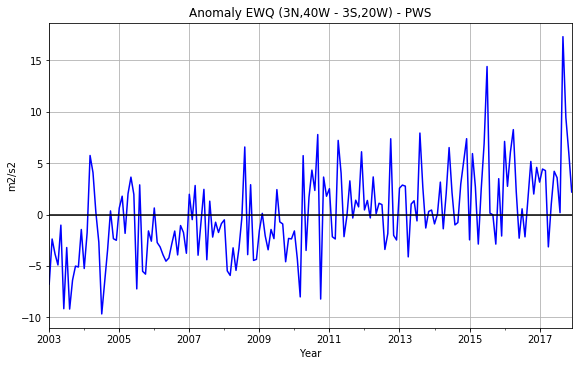

In [33]:
plota_coluna_do_dataframe(ts_df, 'Anomaly EWQ (3N,40W - 3S,20W) - PWS',COLUNA_ANOMALIA_DO_MES)

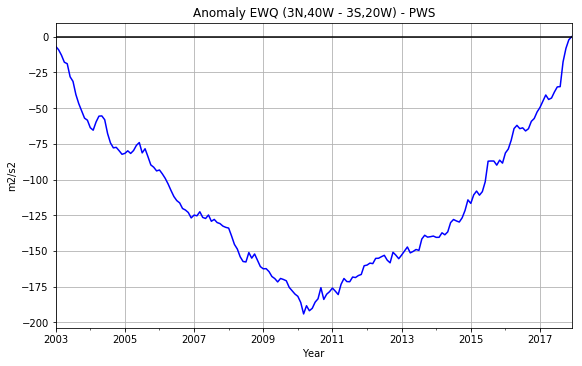

In [34]:
plota_coluna_do_dataframe(ts_df, 'Anomaly EWQ (3N,40W - 3S,20W) - PWS',COLUNA_ANOMALIA_ACUMULADA)